## 1. Regression Methods

### 1.1.1 

date         0
SPX Index    0
dtype: int64


Text(0, 0.5, 'Log Price')

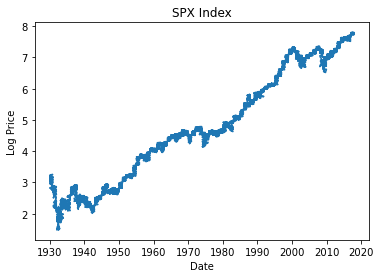

In [4]:
#Importing the necessary libraries and csv files
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

%matplotlib inline
#Reading dates and prices data
px = pd.read_csv("priceData.csv", parse_dates =[0])
px.dropna(inplace=True)
print(px.isna().sum()) #calculate the nubmer of nan values)

#Perform log transform of the prices and plotting it
logpx = px.copy(deep=True)
logpx['Log Price'] = np.log(px['SPX Index'])
logpx.drop(['SPX Index'], axis = 1, inplace=True)

plt.plot(logpx['date'], logpx['Log Price'])
plt.title("SPX Index")
plt.xlabel("Date")
plt.ylabel("Log Price")


### 1.1.2

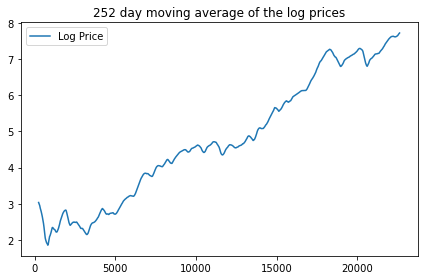

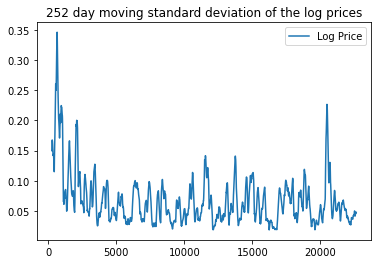

<Figure size 432x288 with 0 Axes>

In [5]:
logpx.rolling(252).mean().plot()
plt.title("252 day moving average of the log prices")
plt.tight_layout()

logpx.rolling(252).std().plot()
plt.title("252 day moving standard deviation of the log prices")
plt.show()
plt.tight_layout()


### Comment on the stationarity of price time-series with reference to your figures.
A loose definition of stationarity is that the first order (mean) and second order(standard deviation) statistics of the distribution does not vary with time. 

The mean of the log prices are not stationary because the mean is clearly increasing over time.

The standard deviation of the log prices do not appear to have a trend however there are spikes within the signal which corresponds to market crashes or corretions. 

The signal is hence non-stationary.

### 1.13 Log Returns and Simple Returns

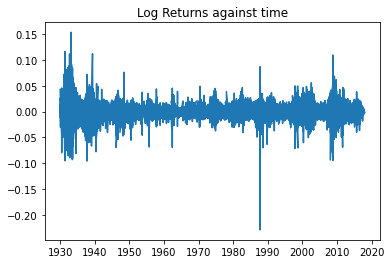

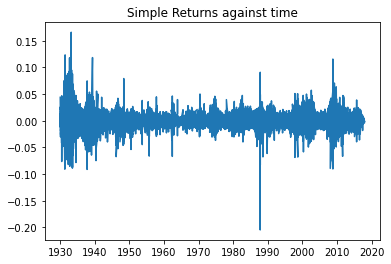

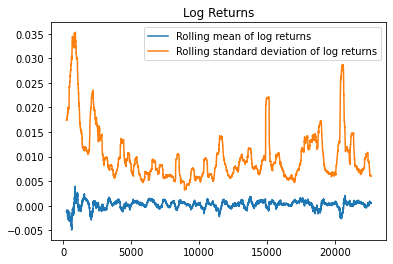

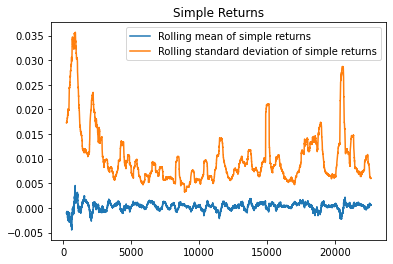

In [6]:
# Log returns
logpx['Log Returns'] = logpx['Log Price'].diff()

#Simple returns

px['Simple Returns'] = px['SPX Index'].pct_change()
plt.plot(logpx['date'],logpx['Log Returns'])
plt.title("Log Returns against time")

plt.figure()
plt.plot(px['date'], px['Simple Returns'])
plt.title("Simple Returns against time")

plt.figure()
logpx['Log Returns'].rolling(252).mean().plot()
logpx['Log Returns'].rolling(252).std().plot()
plt.title("Log Returns")
plt.legend(['Rolling mean of log returns','Rolling standard deviation of log returns'])

plt.figure()
px['Simple Returns'].rolling(252).mean().plot()
px['Simple Returns'].rolling(252).std().plot()

plt.title("Simple Returns")
plt.legend(['Rolling mean of simple returns','Rolling standard deviation of simple returns'])


The rolling mean for both the simple return and log returns have a small oscillatory behaviour around zero which implies a mean-reverting nature of this time-series.

### 1.1.4 Suitability of log returns over simple returns for signal processing practices.

First of all log is monotonically increasing and preserves relative ordering of numbers.
 
The taylor expansion of $log(1+x) = x - x^/2 + x^3/3....$ 

When x is small, $log(1+x) \approx x $

For short period returns, such as daily returns, the absolute value of it : $\frac{r_{t} - r_{t-1}}{r_{t-1}}$ tends to be small.

The log returns $log(r_{t}) - log(r_{t-1}) = log\frac{r_{t}}{r_{t-1}}$
Given that $\frac{r_{t}}{r_{t-1}}$ is small, we can approximate the log returns as $\frac{r_{t}}{r_{t-1}} - 1 = \frac{r_{t}- r_{t-1}}{r_{t-1}}$. That is the return is approximately the log-returns. 
 A consequence of that is that the log-returns are normally distributed which is handy given many statistical techniques presumes normality. Logarithms also provide better numeric stability for various algorithms. This can be further verified with the plots generated below.





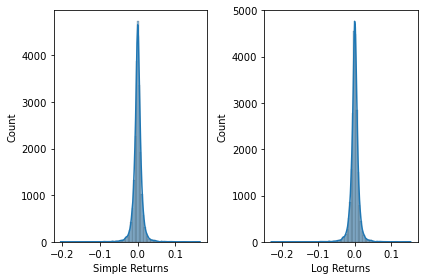

In [7]:
import scipy.stats as st
import seaborn as sns

fig, ax = plt.subplots(1,2)
sns.histplot(px['Simple Returns'], bins = 100, kde = True, ax = ax[0])
sns.histplot(logpx['Log Returns'], bins = 100, kde = True, ax = ax[1])
fig.show()
fig.tight_layout()







Another way to verify the 'Gaussianity' of the data is through the Jarque-Bera goodness of fit test. It measures whether sample data have the skewness and kurtosis matching a normal distribution, which has S (skewness) = 0 and C (kurtosis) = 3.

\begin {equation}
\mathit{JB} = {\frac{n}{6}} (S^{2} + \frac{1}{4}(K-3)^{2})
\end{equation}

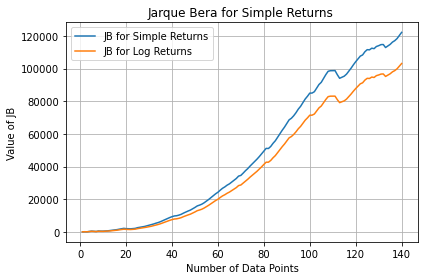

In [8]:
from scipy import stats 
start = 100 ; step = 100
steps = [i for i in range(start, len(px['Simple Returns']), step)]
num_data_points = list(map(lambda x: int(x/step), steps))
simple_JB = [stats.jarque_bera(px['Simple Returns'].dropna()[:s])[0] for s in steps]
log_JB = [stats.jarque_bera(logpx['Log Returns'].dropna()[:s])[0] for s in steps]

# How to plot with axes
fig, ax = plt.subplots()
ax.plot(num_data_points[:140],simple_JB[:140], label = 'JB for Simple Returns')
ax.plot(num_data_points[:140],log_JB[:140], label = 'JB for Log Returns')
ax.title.set_text('Jarque Bera for Simple Returns ')
ax.grid('on')
ax.legend()
ax.set_xlabel("Number of Data Points")
ax.set_ylabel("Value of JB")
fig.tight_layout()


It can be seen as the number of data points increases, the Jarque Bera statistic is increasing. It increases more gradually more gradually for log-returns which implies that log-returns deviate more slowly from a normal distribution proving our previous point of why it is widely used in the signal-processing domain.

### 1.1.5 £1 stock purchase example with log-returns

|$\Delta$ in Stock Price |Simple Returns |Log Returns|
|---|---|---|
|1.00 -> 2.00 | 1.00  | 0.69  |
|2.00 -> 1.00 | -0.5  | -0.69  |

Even though the stock price have no change relative to the initial price of a pound, the simple returns are unequal in magnitude as it is always relative to the starting price you are using. The log returns however are symmetric and sum up to zero
, giving us a clear understanding that the asset did change in value.

### 1.1.6 When should you use simple returns over log returns ? 

In the Markowitz portfolio optimization model, we aim to find a weight vector $\omega$ (vector that contains weighting of each asset) that minimizes the risk measured by the variance $\omega^{T}\Sigma\omega$.

When formulating such a portfolio, we often calculate the mean return by using the simple return vector $r$ which contains the mean return of each individual asset in the portfolio weighted by $\omega$. Hence the mean return can be expressed as $\bar{r} = \omega^{T}{r}$. If we were to use log-returns to model this problem, the expected log-returns will not be a simple weighted-average of the log-returns.


### 1.2 ARMA vs ARIMA models for financial applications

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy

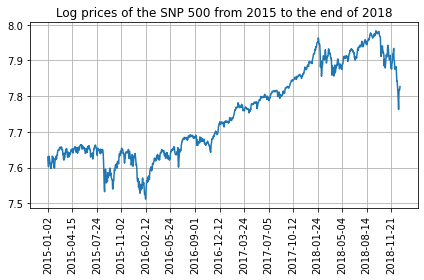

In [10]:
snp = pd.read_csv('snp_500_2015_2019.csv')
date = snp['Date']
snp.set_index(['Date'], inplace = True)
snp_close = snp['Close'].to_frame().apply(np.log)

plt.plot(snp_close)
plt.xticks(date[::70], rotation = 'vertical')
plt.title('Log prices of the SNP 500 from 2015 to the end of 2018')
plt.grid('on')
plt.tight_layout()

Based on the graph above, the log prices of the S&P 500 is non-stationary because there is a steady upward trend over time implying that the mean is increasing. The time-variant first and second order statistics suggest the unsuitability of the ARMA model for this specific time-series as it presumes stationarity. The ARIMA model however has an initial 'differencing step' that can be applied to eliminate the non-stationarity of the mean hence it would be more suitable to use the ARIMA model

### 1.2.2 Fitting an ARMA(1,0) to the S&P 500 index

The model parameter of this AR(1) model is 0.99736. The price signal is can then be formulated mathematically as : 
$$
\begin{equation*}
X_{t} = 0.99736X_{t-1} + \epsilon_{t}
\end{equation*}
$$

This model parameter 0.99736 is close to 1 which means the fitted signal is simply a random walk.

This explains why under close inspection, the fitted signal lags the true signal. The AR(1) model is not useful in practice because it just states that the price movement in the next time step is a random walk based on the price from the previous time step. Future movements are unpredictable and are equally likely to be up or down which is a naive forecast.

C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

const     7.748867
ar.L1     0.997354
sigma2    0.000074
dtype: float64
Sum of Residuals 0.07770956975214016


Text(0.5, 0, 'Date')

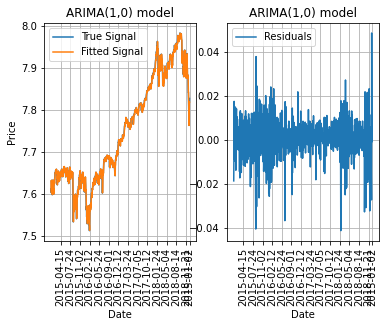

In [11]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']
model = ARIMA(snp_arma, order=(1,0,0)).fit()
snp_arma['Res'] = ARIMA(snp_arma, order=(1,0,0)).fit().resid #(AR,Differences,MA)
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

sum_of_residuals = snp_arma['Res'].sum()

print(model.params)
print("Sum of Residuals", sum_of_residuals)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arma['True'][1:], label = 'True Signal')
ax[0].plot( snp_arma['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arma['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")







### |1.2.3 Fitting an ARIMA(1,1,0) model with differencing

The ARIMA model with differencing removes sources of non-stationarity by applying a differencing step of order 1. The mathematical model for this section can be modelled as : 
$$
\begin{equation*}
\Delta X_{t} = -0.008170 * \Delta X_{t-1} + \epsilon_{t}
\end{equation*}
\\ 
\begin{equation*}
where \Delta X_{t} = X_{t} - X_{t-1}
\end{equation*}
$$

Since \epislon_{t} take values that are much larger than -0.008170 * $\Delta X_{t-1}$ we could approximate the expression such that $\Delta X_{t} \approx \epsilon_{t}$ which reesults in the same conclusion as of 1.2.2.


C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

Sum of residuals for ARIMA 7.828324256613874
ar.L1    -0.008170
sigma2    0.000074
dtype: float64


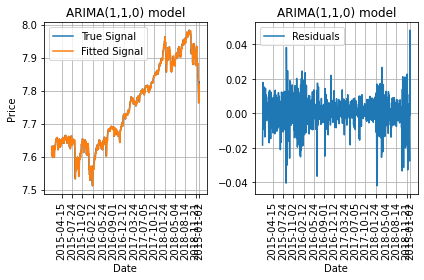

In [12]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ['True']
model_arima = ARIMA(snp_arima, order=(1,1,0)).fit()
snp_arima['Res'] = ARIMA(snp_arima, order=(1,1,0)).fit().resid #(AR,Differences,MA)
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

sum_of_residuals = snp_arima['Res'].sum()
print("Sum of residuals for ARIMA", sum_of_residuals)
print(model_arima.params)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arima['True'][1:], label = 'True Signal')
ax[0].plot( snp_arima['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arima['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")

fig.tight_layout()

### Vector Autoregressive (VAR) models


### 1.3.1 Rewriting the VAR model in concise matrix algebra form.

The equation can be rewritten using matrix algebra.
as $Y = BZ + U $ \
with : \
$B = [c,A_{1},A_{2} ... ,A_{p}]$\
$Z = [1 ,y_{t-1}, y_{t-2}.... ,y_{t-p}]^{T}$\
$Y = y_{t}$ \
$U = e_{t}$

### 1.3.2 $B_{opt}$

The optimal coefficients in the $L_{2}$ sense can be found by posing this as a least-sqaures problem.

\begin{equation}
\min_{Z} ||Y-BZ||^{2}_{2}
\end{equation}

This problem has an analytical solution which could be found by taking the derivative of the objective function.
Let F be the L2 norm of $||Y-BZ||$.
\begin{equation}
\begin{align*}
F = &(Y-BZ)^{T}(Y-BZ) \\
  = & Y^{T}{Y} - 2Y^{T}BZ + (BZ)^{2} \\
\frac{\partial F}{\partial B} =& -2Y^{T}Z + 2(BZ)Z^{T}
\end{align*}
\end{equation}

Setting the partial derivative to zero gives $-2Y^{T}Z + 2(BZ)Z^{T} $ = 0  \
$B(ZZ^{T}) = Y^{T}Z$ \
$B = Y^{T}Z(ZZ^{T})^{-1}$

We obtain $ B_{opt}= Y^{T} Z(ZZ^{T})^{-1}$



### 1.3.3 Eigvenvalues of A must be less than 1 in absolute value

\begin{equation}
y_t = Ay_{t-1} + e_{t}
\end{equation}

Substituting the above equation recursively, we are able to express $y_{t}$ in terms of $\{y_{0}, y_{1} .... y_{t-1}\}$, $A$ and $\{e_{1}, e_{2} ... e_{t}\}$ as : 

\begin{equation}
    y_{t} = \sum_{i=0}^{t-1} (A^{i}e_{t-i}) + A^{t}y_{0}

\end{equation}


For numerical stability, we require tha the eigenvalues of A are lesser than 1, otherwise the values of $y_{t}$ may tend to infinity.

### 1.3.4

In [13]:
from statsmodels.tsa.api import VAR

In [14]:
df = pd.read_csv('snp_allstocks_2015_2019.csv')
df = df.set_index('Date')

info = pd.read_csv('snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)


In [15]:
tickers = ["CAG", "MAR", "LIN", "HCP", "MAT"]
stocks = df[tickers]
stocks_ma = stocks.rolling(window = 66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

#fit a VAR(1) model to the time-series, and compute eigenvalues of A
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)

tmp = pd.DataFrame(A,columns=tickers)
tmp.index = tickers

print(f"eigenvalues of A : {eigA}")
tmp






eigenvalues of A : [0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]


C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,CAG,MAR,LIN,HCP,MAT
CAG,0.872786,0.113179,-0.281265,0.011912,0.058776
MAR,-0.063745,0.895820,-0.184820,-0.005004,0.022917
LIN,0.000134,-0.111678,0.704023,0.004982,-0.025557
HCP,-0.084776,-0.083831,-0.401417,0.931708,-0.046406
MAT,0.643072,0.094931,2.033036,-0.012884,0.802974


1. Firstly, this decompositions show's that stock price at the next time step mostly depends only on the price of itself from the previous step. 

2. The future price of CAG has a correlation with the price of MAT. If MAT moves in one direction, CAG will likely move in the same direction.

3. The future price of LIN also has a correlation with the price of MAT.

Since CAG MAR and LIN have a significant correlation in stock price, this would not be a well-diversified portfolio as prices move together causing it to have a large variance.


The third eigenvalue also has a magnitude > 1 which will result in instability of the model after a long period of time.


## 1.3.5

In [16]:
max_eigen_values = []
mean_eigen_values = []
num_stocks = []


for sector in info['GICS Sector'].unique() : 
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = df[tickers]
    stocks_ma = stocks.rolling(window = 66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()

    #fit a VAR(1) model to the time-series, and compute eigenvalues of A
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)

    tmp = pd.DataFrame(A,columns=tickers)
    tmp.index = tickers

    max_eigen_values.append(eigA.max())
    mean_eigen_values.append(eigA.mean())
    num_stocks.append(len(tickers))


results = pd.DataFrame(info['GICS Sector'].unique(), columns=["Sector"])
results['# of Stocks'] = num_stocks
results['Max Eigenvalue'] = max_eigen_values
results['Mean Eigenvalues'] = mean_eigen_values

results
    

C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

,Sector,# of Stocks,Max Eigenvalue,Mean Eigenvalues
0,Industrials,69,0.991568+0.017404j,0.750818-0.000000j
1,Health Care,62,0.993598+0.033204j,0.441843+0.000000j
2,Information Technology,68,0.992075+0.036269j,0.803445+0.000000j
3,Communication Services,26,0.982234+0.007508j,0.925770+0.000000j
4,Consumer Discretionary,65,0.989860+0.039565j,0.804006+0.000000j
5,Utilities,27,0.983506+0.064941j,0.463644+0.000000j
6,Financials,68,1.003000+0.051864j,0.418911+0.000000j
7,Materials,26,0.990101+0.057061j,0.481792-0.000000j
8,Real Estate,31,0.982744+0.009006j,0.918568+0.000000j
9,Consumer Staples,33,0.991324+0.019122j,0.849384-0.000000j


After performing eigenanalysis, it is worthwhile noticing that not all sectors have their intra-sector tickers moving in tandem. This is evident in the Industrials, HealthCare, Utilities, Financials and Materials sectors where future stock price movement of intra-sector tickers have a low mean eigenvalue. This low intra-sector correlation implies that it is worthwhile diversifying across these 5 sectors.
The portfolio manager can then diversify across sectors by buying one from the other 5 sectors with high intra-sector correlation.

## 2. Bond Pricing

### 2.1 Examples of Bond Pricing

\begin{equation*}
FCF  = NPV  (1+\frac{r}{n})^{nt} 
\end{equation*}
\begin{equation*}
r = n[(\frac{FCF}{NPV})^{\frac{1}{nt}} - 1]
\end{equation*}

NPV is the net present value or in our case the initial investment made. \
While FCF is the future cash flow we will receive at the end of the time period $t$. \
$n$ is the compounding frequency 

1. Annual Compounding
$n =1, t=1, FCF = 1100, NPV = 1000$ this gives 
\begin{equation*}
r = 10\%
\end{equation*}

2. Semi-annual Compounding
$n =1, t=1, FCF = 1100, NPV = 1000$ this gives 
\begin{equation*}
r = 9.76\%
\end{equation*}

3. Monthly compounding
$n=12, t=1, FCF =1100, NPV = 1000$ this gives
\begin{equation*}
r = 9.57\%
\end{equation*}

4. Continuous Compounding
$n -> {\infty}, t=1, FCF = 1100, NPV = 1000 $ this gives

Knowing the fact that as $n -> {\infty}$, the expression of FCF can be reduced to an exponential.
\begin {equation*}
\begin {aligned}
FCF =& \lim_{n->\infty} NPV(1+\frac{r}{n})^{nt} \\
FCF =& NPV(e^{rt}) 
\end{aligned}
\end{equation*}

We can then rewrite r as 
\begin{equation*}
r = \frac{ln(\frac{FCF}{NPV})}{t}
\end{equation*}

which gives 
\begin{equation*}
 r= 9.53 \%
\end{equation*}

### 2.1.2 Equivalent rate of interest for continuous compounding
We find the equivalent rate of interest for continuous compounding by equating their future cash flow.
For monthly compounding, we plug in n = 12, 

$FCF_{cont} = FCF_{monthly}$ \
$NPV e^{r_{cont}t} = NPV (1+\frac{r_{monthly}}{n})^{nt}$ \
$e^{r_{cont}} = (1+\frac{0.15}{12})^{12}$ \
$r_{cont} = \ln(1+\frac{0.15}{12})^{12}$ \
$r_{cont} = 14.9\%$


### 2.1.3 Interest paid for continuous compounding

Interest for : \
$Q1 = 10000(e^{0.12*1/4} -1) = \$304.55 $ 

$Q2 = 10000(e^{0.12*2/4}-1) - Q1 = \$313.82$

$Q3 = 10000(e^{0.12*3/4} -1) - Q1 - Q2 = \$323.38$

$Q4 = 10000(e^{0.12}-1) - Q1 - Q2 - Q3 = \$333.23 $


### 2.2 Forward rates

2.2.1

a) Theoretically the forward rates of interest between $f_{1,2}$ have already been implied in the two-year interest rate. The 9% 'extra return' we've obtained would be the same as investing in the one-year interest rate now, and taking all the proceeds and reinvest in the one-year interest rate one year later (provided that market expectations remain the same).



b) 
1. 5% - If the investor needs the capital invested in one-year this is the only sound option. 
2.   7% - If the investor has predictions that rates will go down in a year much lower than the implied forward rate $f_{1,2}$, and he doesn't need this capital for 2 years from now then this is a good option. The investor can lock in a higher return with the current interest rate by investing in the two year strategy. 
3.   9% - The investor has predictions that rates may go up higher than the implied forward rate $f_{1,2}$ in a year. This investor can reinvest his proceeds from the first year.

c) The advantage of forwards rates is that is gives investors an idea of what the interest rate one year from now as they are based on market expectations. The disadvantage is that it is subject to interest rate fluctuations.


d) The investor's belief of the interest rate one year from now would have to be lesser than 9% for him to invest in the 2 year strategy. It depends on the future macro-environment and the decisions made by central banks.




### 2.3 Duration of a coupon bearing bond

a) The duration of the bond is simply the sum of the weighted averages show in the 4th row of the table. 

\begin{equation*}
0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595
\end{equation*}

b) 
\begin {aligned}
D_{M}=& \frac{duration}{1+yield} \\
     =& \frac{6.7595}{1+0.05} \\
     =& 6.438\%
\end{aligned}

The modified duration measures the percentage change of price with respect to yield while duration(Macaulay duration) is just the weighted average time until cash flows are received. Their numerical values are quite similar as they only differ by a factor of (1+YTM)

c) Firstly, interest rate fluctuations are inversely proportional to the pricing of a bond. So bond prices are subject to interest rate risks. We can write the taylor's expansion of the price of the bond with respect to the YTM $\lambda$ as 

\begin{equation}
P(\lambda) = P(\lambda_{0}) + \frac{dP(\lambda_{0})}{\lambda}(\lambda - \lambda_{0}) + 
\frac{1}{2}\frac{d^{2}P(\lambda_{0})}{d\lambda^{2}}(\lambda-\lambda_{0})^{2} + ....
\end{equation}

Pension funds can then mitigate risks of changing interest rates $d\lambda$ by matching first and second order terms of P which are simply the a scalar multiple of the modified duration and the derivative of the modified duration respectively.


<!-- c)
\begin{aligned}


\end{aligned} -->

### 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv(r'fsp_case_31_BSD.csv', index_col=0, header=[0,1])
df.index = pd.to_datetime(df.index)


df['ret'].mean(axis=1)

2017-01-02    0.007347
2017-01-03    0.000909
2017-01-04   -0.002181
2017-01-05    0.002953
2017-01-06    0.000993
                ...   
2018-12-25    0.000000
2018-12-26    0.000936
2018-12-27   -0.017501
2018-12-28    0.017471
2018-12-31    0.005764
Length: 521, dtype: float64

### 2.4.1 The estimated market returns per day is given by : 

The 157 European companies averaged a return of 0.004% a day across the 2017-2019 timeframe.

In [18]:
(df['ret'].mean(axis=1)*100).mean()

0.0046020244630060525

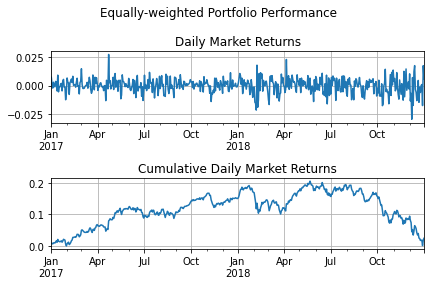

In [59]:
unweighted_returns = df['ret'].mean(1)
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle("Equal-Weighted Portfolio Performance")
unweighted_returns.plot(ax=ax1, grid=True)
unweighted_returns.cumsum().plot(ax=ax2, grid=True)

ax1.set_title("Daily Market Returns")
ax2.set_title("Cumulative Daily Market Returns")
fig.set_size_inches(6,4)
fig.tight_layout()

### 2.4.2 Estimate a rolling beta, $\beta_{i,t}$ for each company i, with the rolling window of 22 days.

The market beta $\beta_{i}$ is defined as : 

\begin{equation}
\beta_{i} = \frac{Cov(R_{i},R_{m})}{Var({R_{m})}}
\end{equation}

A 22 days rolling $\beta_{i,t}$ would be a time series of $\beta s$ measured for every 22 day periods. We take $R_{m}$ to be the equally-weighted average return of the 157 European companies.


In [70]:
def rolling_beta (period,df,weighted=False, market_returns=None) : 
    Beta_t_2d_list = []
    for t_1, t_2 in zip(df.index[0:],df.index[21:]) : 
        R_i = df[t_1:t_2]['ret']
        if not weighted : ## equally weighted
            R_m = pd.Series(df[t_1:t_2]['ret'].mean(axis=1))
        else :  ##market-cap weighted
            R_m = market_returns[t_1:t_2]
        Beta_t_vals = []
        for name, data in  R_i.iteritems() :
            Beta = R_m.cov(data) / R_m.cov(R_m)
            Beta_t_vals.append(Beta)
        Beta_t_2d_list.append(Beta_t_vals)

    Beta_df = pd.DataFrame(Beta_t_2d_list, index = df['ret'].index[21:],columns = df['ret'].columns)

    return Beta_df

Beta_df = rolling_beta(period=22, df=df, weighted=True)





AttributeError: 'NoneType' object has no attribute 'empty'

cmp_id       G_AALLN   G_ABIBB    G_ACFP  G_ADENVX  G_ADLERR    G_ADNA  \
2017-01-31  1.120084  0.758502  1.365775  0.561307  2.021471  1.025299   
2017-02-01  1.287892  0.759152  1.457017  0.711729  2.868834  1.055401   
2017-02-02  1.255190  0.801367  1.385048  0.667787  2.775183  1.084868   
2017-02-03  0.965485  0.863929  1.600480  0.772751  2.776015  1.094787   
2017-02-06  1.030465  0.799321  1.587402  0.729256  2.559747  1.179950   
...              ...       ...       ...       ...       ...       ...   
2018-12-25  1.712950  0.986925  1.019274  1.328616  0.077245  0.483996   
2018-12-26  1.981228  1.071848  1.083719  1.332307 -0.013655  0.504539   
2018-12-27  1.932315  1.061517  1.068728  1.360348  0.064691  0.490179   
2018-12-28  1.773167  0.972899  1.104357  1.379742 -0.005508  0.470399   
2018-12-31  1.670160  0.970832  1.168231  1.324555 -0.014196  0.482117   

cmp_id        G_AFFP    G_AIFP   G_AIRFP  G_AKZANA  ...   G_TUIGR   G_UNANA  \
2017-01-31  0.850112  1.100991  

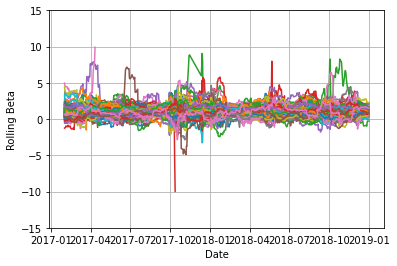

In [43]:
print(Beta_df)

for col in Beta_df.columns : 
    tmp = Beta_df[col][Beta_df[col].between(-10,10)] #filter values with betas that are too high
    plt.plot(tmp)
plt.xlabel('Date')
plt.ylabel('Rolling Beta')
plt.ylim([-15,15])
plt.grid('on')
plt.show()






Beta measures the expected move in a stock relative to movements in the overall market. It is a key component of the CAPM model and can be used in calculating the cost of equity funding.

$ \beta < 0$ means that the asset moves in opposite directions with the market portfolio.

$0 < \beta < 1$ means that the asset moves with the market portfolio but with lower magnitudes.

$\beta > 1$ means that the asset moves with the market portfolio and does it with larger magnitudes. (Gains and losses are amplified)\

Negative beta stocks are rare, in the plot you can see only a handful of stocks have negative beta on average.

### 2.4.3 Estimating the market-cap weighted market return $R_{m}$


\begin{equation}
R_{m} = \sum_{i} \frac{mcap * ret_{i}}{\sum_{i}mcap_{i}}
\end{equation}

The return of the market is the sum of the returns of individual equities weighted by their market capitalization 
$w = \frac{mcap_{i}}{\sum_{i}mcap_{i}}$. 

In [61]:
total_market_cap = df['mcap'].sum(axis=1)
market_returns = df['ret'].multiply(df['mcap'])
R_m = market_returns.sum(axis=1).divide(total_market_cap)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle("Market Portfolio Performance")
R_m.plot(ax=ax1, grid=True)
R_m.cumsum().plot(ax=ax2, grid=True)
ax1.set_title("Daily Returns")
ax2.set_title("Cumulative Daily Returns")
fig.tight_layout()


2017-01-02    0.005367
2017-01-03    0.000738
2017-01-04    0.000089
2017-01-05    0.003381
2017-01-06    0.000410
                ...   
2018-12-25    0.000000
2018-12-26    0.000056
2018-12-27   -0.017349
2018-12-28    0.018069
2018-12-31    0.003588
Length: 521, dtype: float64


### 2.4.4 Estimating a cap-weighted $\beta$

In [68]:
cap_weighted_beta_df = rolling_beta(22,df,R_m)

In [69]:
print(cap_weighted_beta_df)

cmp_id       G_AALLN   G_ABIBB    G_ACFP  G_ADENVX  G_ADLERR    G_ADNA  \
2017-01-31  1.214037  0.824742  1.450022  0.655882  1.838878  0.704193   
2017-02-01  1.431328  0.783674  1.494303  0.750567  2.083210  0.721606   
2017-02-02  1.461266  0.811729  1.421213  0.714549  2.103411  0.743513   
2017-02-03  1.517930  0.803336  1.377390  0.659456  2.078194  0.755078   
2017-02-06  1.674576  0.746702  1.268294  0.699650  2.124648  0.903941   
...              ...       ...       ...       ...       ...       ...   
2018-12-25  1.868667  0.904925  0.848940  1.440384  0.110910  0.250401   
2018-12-26  2.496684  1.048936  0.927484  1.466695  0.063767  0.219777   
2018-12-27  2.496645  1.048969  0.927533  1.466684  0.063726  0.219783   
2018-12-28  2.500924  1.038451  0.903094  1.459363 -0.039548  0.210867   
2018-12-31  2.428767  0.999223  0.974398  1.336002 -0.064062  0.264533   

cmp_id        G_AFFP    G_AIFP   G_AIRFP  G_AKZANA  ...   G_TUIGR   G_UNANA  \
2017-01-31  0.816950  1.119753  